# ARIMA: Autoregressive Integrated Moving Average

**File:** ARIMA.ipynb

**Course:** Data Science Foundations: Data Mining in Python

# INSTALL AND IMPORT LIBRARIES
This demonstration requires the `pdarima` library, which can be installed with Python's `pip` command. This command only needs to be done once per machine. This is an example of SARIMAX model where there is seasonality seen in data

The standard, shorter approach may work:

In [ ]:
# pip install pmdarima

If the above command didn't work, it may be necessary to be more explicit, in which case you could run the code below.

In [ ]:
# import sys
# !{sys.executable} -m pip install pmdarima

Once `pdarima` is installed, then load the libraries below.

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima

# LOAD AND PREPARE DATA

In [3]:
df = pd.read_csv('/Users/sumedhajauhari/Desktop/My Study Material/Ex_Files_Data_Mining_Python_R/Exercise Files/data/AirPassengers.csv', parse_dates=['Month'], index_col=['Month'])
df.head(10)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [9]:
df1 = pd.read_csv('/Users/sumedhajauhari/Desktop/My Study Material/Ex_Files_Data_Mining_Python_R/Exercise Files/data/AirPassengers.csv')
df1.columns

Index(['Month', '#Passengers'], dtype='object')

In [16]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


# PLOT DATA

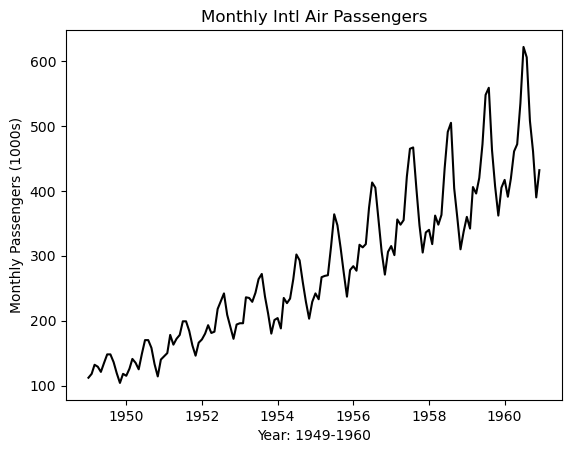

In [7]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(df, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
#if you see graph is trending upwards that means data is non stationary. There is seasonality

In [10]:
#using another test to verify data stationary or not. let's use Augmented Dickey-Fuller (ADF) test. P-value >0.05 means non stationary data
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['#Passengers'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: 0.8153688792060416
p-value: 0.9918802434376409


# SPLIT DATA

- Our goal is to predict future values in the time series.
- To do this, we'll use data from 1949 through 1957 for training the model.
- We'll then use data from 1958 through 1960 for testing the predictions.

## Create Training Dataset

- Select data from before 1958.

In [23]:
trn = df.loc[df.index < '1958-01-01']

- Plot the training data.

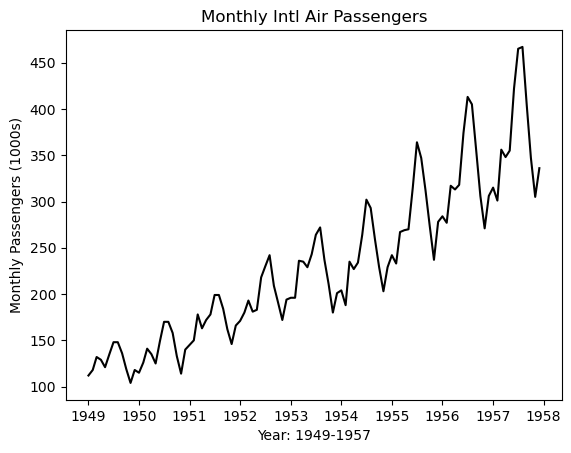

In [24]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(trn, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

## Create Testing Dataset

- Use data from 1958 through 1960 (the last three years) for testing.

In [25]:
tst = df.loc[df.index >= '1958-01-01']

- Plot the testing data.
- Note that the vertical scale changes from the previous graph.

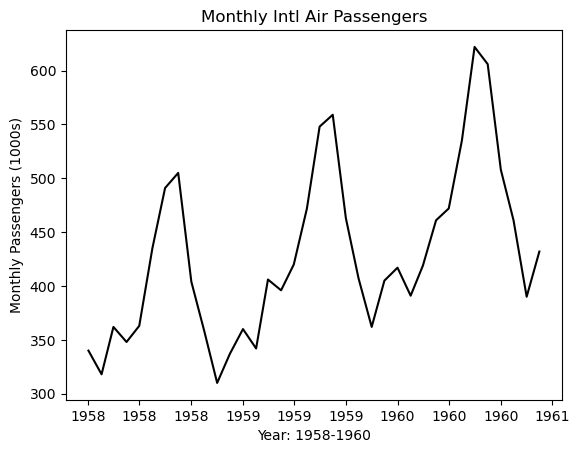

In [26]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1958-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(tst, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# PREPARE MODEL

## Test Stationarity

ARIMA requires stationary data. That is, ARIMA needs data where the mean, the variance, and/or the covariance does not vary over time. That is why for non-stationary data we have to do lag. It shows significant correlations when lagged. A "correlogram" graph (or ACF plot) shows the degree of correlation at different values of lag. Ideally, none of the lag values will fall in the range of nonsignificant correlations.

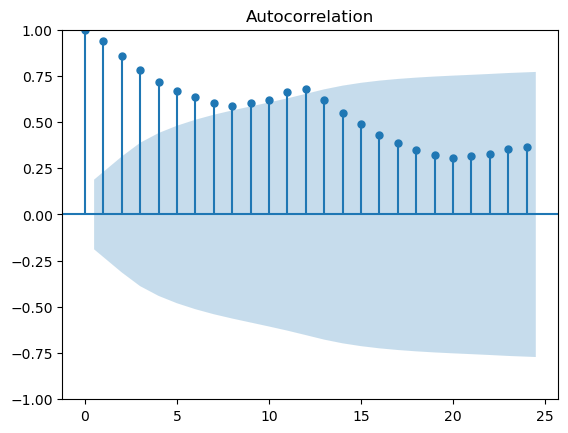

In [29]:
trn_acf = plot_acf(trn, lags=24)
#you see 13 points here are out of blue regioon these are the ones that shows significant correlations rest is the noise.lags=13 is what we require

## Linear Model

- Fit a linear regression model to serve as a baseline. 
- The dependent (or endogenous) variable is the number of passengers. 
- The independent (or exogenous) variable is a linear time trend, including a constant (or intercept).

In [28]:
lr = sm.OLS(endog=trn['#Passengers'], exog=sm.add_constant(np.arange(1, 1 + trn.shape[0]))).fit() 
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:            #Passengers   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     526.7
Date:                Sun, 26 May 2024   Prob (F-statistic):           6.40e-43
Time:                        21:44:42   Log-Likelihood:                -536.80
No. Observations:                 108   AIC:                             1078.
Df Residuals:                     106   BIC:                             1083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.0422      6.820     13.936      0.0

- Extract the fitted values.

In [30]:
y_hat = lr.fittedvalues

- Extract the 95% prediction interval.

In [31]:
y_ci = lr.get_prediction().conf_int(alpha=0.05)

- Graph time series with linear regression line and corresponding 95% prediction interval.

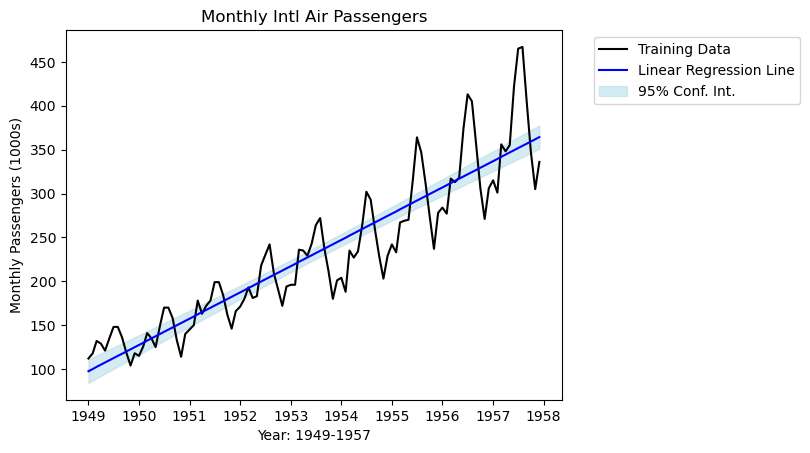

In [33]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(trn, color='black', label='Training Data')
plt.plot(y_hat, color='blue', label='Linear Regression Line')
plt.fill_between(y_hat.index, y_ci[:, 0], y_ci[:, 1], color='lightblue', alpha=0.5, label='95% Conf. Int.')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
#if you see here prediction is straight line it is not taking into account seasonality so its better to use SARIMAX model and not linear regresson for time series forecast

# ARIMA: TRAIN MODEL

Find the best ARIMA order using the `auto_arima` function in the `pmdarima` package. Note that the `auto_arima` function assumes that the time series is non-seasonal by default (i.e. the seasonal period "m" is set equal to 1 by default). In what follows we set "m" equal to 12 to ensure that the selected optimal model takes into account the annual seasonality observed in the time series (one cycle every 12 months).    

Note: We are actually conducting a variation on ARIMA called "SARIMAX," or "Seasonal Auto-Regressive Integrated Moving Average with Exogenous Factors."

In [35]:
auto_arima_model = auto_arima(trn, m=12, with_intercept=False, suppress_warnings=True)
print(auto_arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -350.001
Date:                            Mon, 27 May 2024   AIC                            704.001
Time:                                    10:59:13   BIC                            709.109
Sample:                                01-01-1949   HQIC                           706.065
                                     - 12-01-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2411      0.091     -2.648      0.008      -0.420      -0.063
sigma2        92.7499     13.439   

- The `auto_arima` function suggests `ARIMA(1,1,0)(0,1,0,12)`.    

First set of numbers is for the basic, non-seasonal model    
&nbsp;  1 &nbsp;&nbsp;&nbsp;    # p: Auto-regressive (AR) order   
&nbsp;  1 &nbsp;&nbsp;&nbsp;    # d: Integrate (I), or degree of differencing   
&nbsp;  0 &nbsp;&nbsp;&nbsp;    # q: Moving average (MA) order   

In [36]:
auto_arima_model.order

(1, 1, 0)

Second set of numbers is for seasonality    
&nbsp;  0 &nbsp;&nbsp;&nbsp;    # P: Auto-regressive (AR) order    
&nbsp;  1 &nbsp;&nbsp;&nbsp;    # D: Integrate (I), or degree of differencing    
&nbsp;  0 &nbsp;&nbsp;&nbsp;    # Q: Moving average (MA) order   
&nbsp;  12 &nbsp;  # M: Model period or seasonality   

In [37]:
auto_arima_model.seasonal_order

(0, 1, 0, 12)

- Extract the residuals. 

In [38]:
resid = auto_arima_model.resid()

- Plot the standardized residuals.

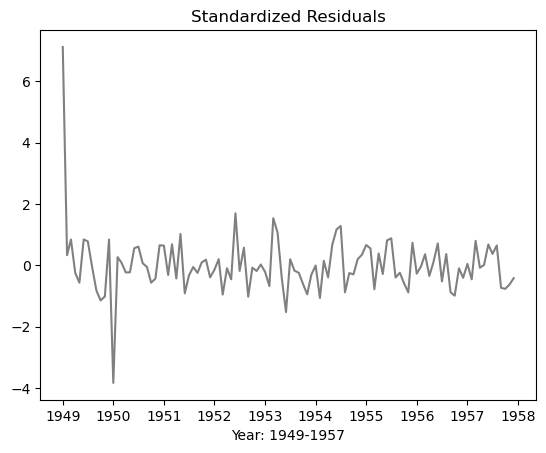

In [40]:
fig, ax = plt.subplots()
plt.plot(trn.index, stats.zscore(resid), color='gray')
plt.title('Standardized Residuals')
plt.xlabel('Year: 1949-1957')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
#you see residuals are mostly concentrated at 0 except at the beginning i.e. model is predicting things wellll in training data

- Plot the ACF (autocorrelation function) of the residuals. 

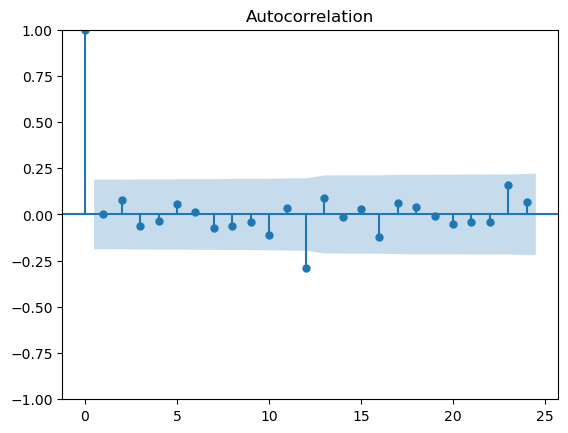

In [42]:
res_acf = plot_acf(resid, lags=24)
#same observations residualls mostly around 0 except a few up and down
# nearly all of them are in the region of non-significant, so they are not statistical significant. 
#That's a good thing with residuals. It means they're all pretty close to zero, aside from this very first one,


- Plot the p-values of the Ljung-Box test for autocorrelation.

In [48]:
#this is another validation ljungbox to check p value for statistically significant. Value should be >0.05 to be non significant
#res_lb = acorr_ljungbox(resid, lags=24, return_df=False)[1]

try:
    res_lb = acorr_ljungbox(resid, lags=24, return_df=True)
    # Access the p-values column
    p_values = res_lb['lb_pvalue']
    print("Ljung-Box test p-values for lags 1 to 24:", p_values)
except KeyError as e:
    print(f"KeyError: {e}")
except Exception as e:
    print(f"An error occurred: {e}")
    


Ljung-Box test p-values for lags 1 to 24: 1     0.983222
2     0.722920
3     0.784735
4     0.874231
5     0.901238
6     0.950434
7     0.942999
8     0.947955
9     0.966022
10    0.924728
11    0.948878
12    0.234921
13    0.242589
14    0.304790
15    0.366263
16    0.313146
17    0.344307
18    0.394412
19    0.458833
20    0.500267
21    0.550111
22    0.596634
23    0.447838
24    0.469713
Name: lb_pvalue, dtype: float64


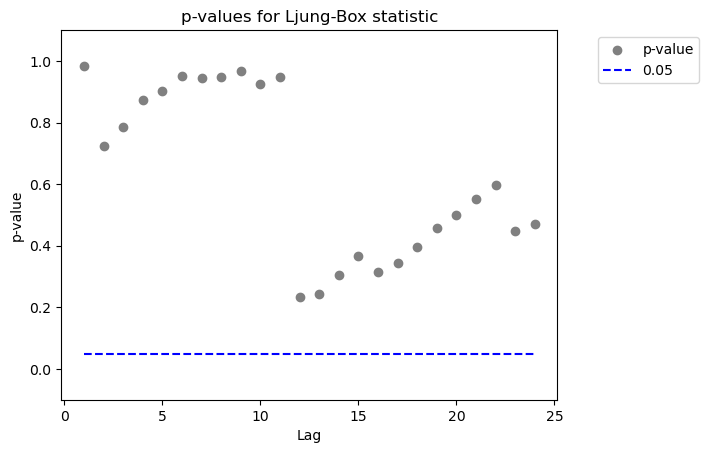

In [50]:
"""fig, ax = plt.subplots()
plt.title('p-values for Ljung-Box statistic')
plt.scatter(np.arange(1, 1 + len(res_lb)), res_lb, color='gray', label='p-value')
plt.plot(np.arange(1, 1 + len(res_lb)), [0.05] * len(res_lb), '--', color='blue', label='0.05')
plt.ylim(-0.1, 1.1)
plt.legend(bbox_to_anchor=(1.3, 1)) """

# Plotting
fig, ax = plt.subplots()
plt.title('p-values for Ljung-Box statistic')
plt.scatter(np.arange(1, 1 + len(p_values)), p_values, color='gray', label='p-value')
plt.plot(np.arange(1, 1 + len(p_values)), [0.05] * len(p_values), '--', color='blue', label='0.05')
plt.ylim(-0.1, 1.1)
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.show()


# TEST MODEL

- Fit the best model to the training data.

In [53]:
auto_arima_model.fit(trn)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

- Use the model to predict intervals for last three years.
- That is, apply the model to the testing dataset.

In [54]:
arima_predictions = auto_arima_model.predict(n_periods=36, alpha=0.05, return_conf_int=True)

- Extract the time series of model predictions.

In [55]:
y_pred = pd.Series(arima_predictions[0], index=tst.index)

- Extract the 95% prediction interval.

In [56]:
y_pred_lb, y_pred_ub = arima_predictions[1][:, 0], arima_predictions[1][:, 1]

- Graph the training data (1949-1957).
- Add the predictions for the testing data (1958-1960).
- Add observed values from testing data.

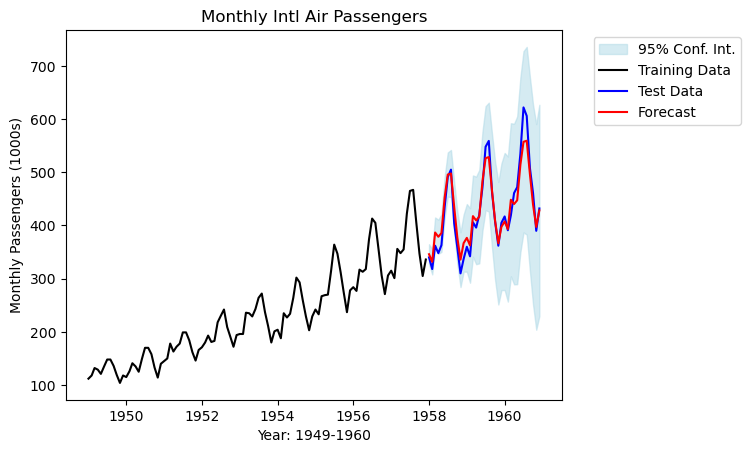

In [57]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.fill_between(tst.index, y_pred_lb, y_pred_ub, color='lightblue', alpha=0.5, label='95% Conf. Int.')
plt.plot(trn, color='black', label='Training Data')
plt.plot(tst, color='blue', label='Test Data')
plt.plot(y_pred, color='red', label='Forecast')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

#you can see here ARIMA model is predicting so well (red line) based on trend as well as seasonality. Test data starts in Blue line

- Create a dataframe with the observed values for the testing dataset.
- Add the predictions from the ARIMA model.
- Add the low and high boundaries for the 95% confidence intervals.

In [58]:
tst_pred = pd.DataFrame({
    'Actual': tst.iloc[:, 0].values, 
    'Point Forecast': y_pred.values, 
    'Lo 95': y_pred_lb,
    'Hi 95': y_pred_ub
    }, index=tst.index)

In [59]:
tst_pred.head()

,Actual,Point Forecast,Lo 95,Hi 95
Month,,,,
1958-01-01,340,345.964471,327.088699,364.840243
1958-02-01,318,331.731920,308.036230,355.427610
1958-03-01,362,386.787992,358.515740,415.060244
1958-04-01,348,378.774472,346.695454,410.853490
1958-05-01,363,385.777732,350.270764,421.284700


# Clean Up

- If desired, clear the results with Cell > All Output > Clear. 
- Save your work by selecting File > Save and Checkpoint.
- Shut down the Python kernel and close the file by selecting File > Close and Halt.

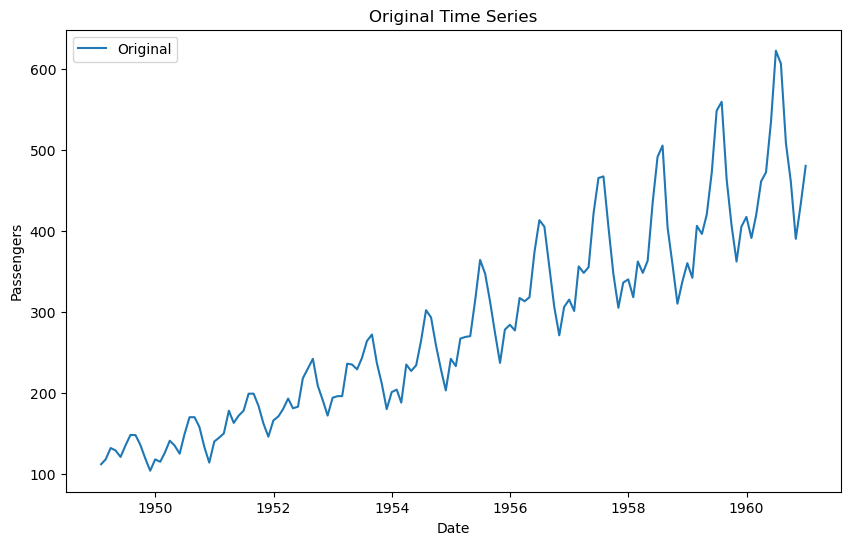

ADF Statistic: 1.4327619230088757
p-value: 0.9972580085618967


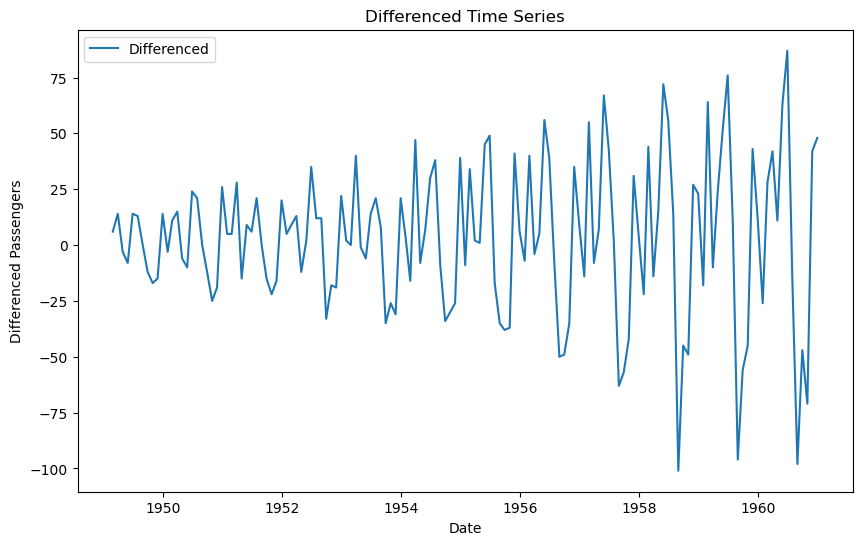

ADF Statistic after differencing: -3.493345092350522
p-value after differencing: 0.008159660141430405


In [12]:
# This is a sample example of ARIMA Model where we have a non stationary data and we are making it Stationary by differencing the time series.
#perform dfferencing once do ADF test and check if series is stationary or not if not then perform differencing again

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Load a sample dataset (monthly airline passengers)
# For illustration, let's generate a non-stationary time series
dates = pd.date_range(start='1949-01-01', periods=144, freq='M')
data = [112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118,
        115, 126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140,
        145, 150, 178, 163, 172, 178, 199, 199, 184, 162, 146, 166,
        171, 180, 193, 181, 183, 218, 230, 242, 209, 191, 172, 194,
        196, 196, 236, 235, 229, 243, 264, 272, 237, 211, 180, 201,
        204, 188, 235, 227, 234, 264, 302, 293, 259, 229, 203, 242,
        233, 267, 269, 270, 315, 364, 347, 312, 274, 237, 278, 284,
        277, 317, 313, 318, 374, 413, 405, 355, 306, 271, 306, 315,
        301, 356, 348, 355, 422, 465, 467, 404, 347, 305, 336, 340,
        318, 362, 348, 363, 435, 491, 505, 404, 359, 310, 337, 360,
        342, 406, 396, 420, 472, 548, 559, 463, 407, 362, 405, 417,
        391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 432, 480]

# Create a DataFrame
df = pd.DataFrame(data, index=dates, columns=['Passengers'])

# Plot the original time series
plt.figure(figsize=(10, 6))
plt.plot(df, label='Original')
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

# Check stationarity with ADF test
result = adfuller(df['Passengers'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Perform differencing
df_diff = df.diff().dropna()

# Plot the differenced time series
plt.figure(figsize=(10, 6))
plt.plot(df_diff, label='Differenced')
plt.title('Differenced Time Series')
plt.xlabel('Date')
plt.ylabel('Differenced Passengers')
plt.legend()
plt.show()

# Check stationarity again with ADF test
result_diff = adfuller(df_diff['Passengers'])
print(f'ADF Statistic after differencing: {result_diff[0]}')
print(f'p-value after differencing: {result_diff[1]}')
